<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Multimodal_EfficientNetV2B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets list -s "ovarian cancer"

ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2920         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3571         49  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1652         39  1.0          

In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# -----------------------------
# Load and preprocess image data
# -----------------------------
IMG_SIZE = 224
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {name: i for i, name in enumerate(classes)}

X_images, y_labels = [], []

def augment_image(img):
    img = cv2.flip(img, 1) if np.random.rand() < 0.5 else img
    return img

for class_name in classes:
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder): continue
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = augment_image(img)
        img = preprocess_input(img)
        X_images.append(img)
        y_labels.append(class_mapping[class_name])

X_images = np.array(X_images)
y_labels = to_categorical(y_labels, num_classes=len(classes))

# -----------------------------
# Load and preprocess tabular data
# -----------------------------
df = pd.read_csv("Ovarian_patient_data.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
features = ['age', 'ca125', 'cancerstage', 'bmi']
df = df.dropna(subset=features).reset_index(drop=True)
df = df.iloc[:len(X_images)]  # Ensure alignment

scaler = StandardScaler()
X_tabular = scaler.fit_transform(df[features].values)

# -----------------------------
# Train-test split
# -----------------------------
X_train_img, X_test_img, X_train_tab, X_test_tab, y_train, y_test = train_test_split(
    X_images, X_tabular, y_labels, test_size=0.2, random_state=42
)

# -----------------------------
# Build multimodal model
# -----------------------------
image_input = Input(shape=(224, 224, 3), name="image_input")
base_model = EfficientNetV2B2(include_top=False, weights="imagenet", input_tensor=image_input, pooling="avg")
base_model.trainable = True
x = layers.Dense(256, activation="relu")(base_model.output)
x = layers.Dropout(0.4)(x)

# Tabular model - enhanced
tabular_input = Input(shape=(X_tabular.shape[1],), name="tabular_input")
y = layers.Dense(128, activation="relu")(tabular_input)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.3)(y)
y = layers.Dense(64, activation="relu")(y)
y = layers.BatchNormalization()(y)
y = layers.Dense(32, activation="relu")(y)

# Combine
combined = layers.Concatenate()([x, y])
z = layers.Dense(256, activation='relu')(combined)
z = layers.Dropout(0.4)(z)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dropout(0.3)(z)
output = layers.Dense(len(classes), activation='softmax')(z)

model = Model(inputs=[image_input, tabular_input], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# -----------------------------
# Callbacks
# -----------------------------
checkpoint = ModelCheckpoint("best_model_b2.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    [X_train_img, X_train_tab],
    y_train,
    validation_data=([X_test_img, X_test_tab], y_test),
    epochs=25,
    batch_size=16,
    callbacks=[checkpoint, lr_reducer, early_stop]
)

# -----------------------------
# Evaluate
# -----------------------------
model.load_weights("best_model_b2.h5")
loss, acc = model.evaluate([X_test_img, X_test_tab], y_test)
print(f"\n✅ Best Accuracy with EfficientNetV2B2: {acc * 100:.2f}%")


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2100 - loss: 1.6665
Epoch 1: val_accuracy improved from -inf to 0.35000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 246s 6s/step - accuracy: 0.2103 - loss: 1.6662 - val_accuracy: 0.3500 - val_loss: 1.5665 - learning_rate: 1.0000e-04
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2762 - loss: 1.5984
Epoch 2: val_accuracy improved from 0.35000 to 0.45000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.2757 - loss: 1.5978 - val_accuracy: 0.4500 - val_loss: 1.5438 - learning_rate: 1.0000e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3095 - loss: 1.5833
Epoch 3: val_accuracy improved from 0.45000 to 0.54000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - accuracy: 0.3094 - loss: 1.5824 - val_accuracy: 0.5400 - val_loss: 1.4998 - learning_rate: 1.0000e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4274 - loss: 1.4736
Epoch 4: val_accuracy improved from 0.54000 to 0.59000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.4264 - loss: 1.4737 - val_accuracy: 0.5900 - val_loss: 1.4400 - learning_rate: 1.0000e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5055 - loss: 1.3889
Epoch 5: val_accuracy improved from 0.59000 to 0.67000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.5052 - loss: 1.3884 - val_accuracy: 0.6700 - val_loss: 1.3416 - learning_rate: 1.0000e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5634 - loss: 1.3116
Epoch 6: val_accuracy improved from 0.67000 to 0.69000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - accuracy: 0.5642 - loss: 1.3096 - val_accuracy: 0.6900 - val_loss: 1.2291 - learning_rate: 1.0000e-04
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5601 - loss: 1.2325
Epoch 7: val_accuracy improved from 0.69000 to 0.72000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.5626 - loss: 1.2307 - val_accuracy: 0.7200 - val_loss: 1.1097 - learning_rate: 1.0000e-04
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7131 - loss: 1.0932
Epoch 8: val_accuracy did not improve from 0.72000
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.7121 - loss: 1.0926 - val_accuracy: 0.7100 - val_loss: 0.9912 - learning_rate: 1.0000e-04
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7811 - loss: 0.9314
Epoch 9: val_accuracy improved from 0.72000 to 0.76000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - accuracy: 0.7816 - loss: 0.9304 - val_accuracy: 0.7600 - val_loss: 0.8969 - learning_rate: 1.0000e-04
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8423 - loss: 0.7947
Epoch 10: val_accuracy improved from 0.76000 to 0.80000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.8419 - loss: 0.7946 - val_accuracy: 0.8000 - val_loss: 0.8627 - learning_rate: 1.0000e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8594 - loss: 0.7969
Epoch 11: val_accuracy improved from 0.80000 to 0.86000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.8598 - loss: 0.7949 - val_accuracy: 0.8600 - val_loss: 0.7827 - learning_rate: 1.0000e-04
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9168 - loss: 0.6652
Epoch 12: val_accuracy improved from 0.86000 to 0.87000, saving model to best_model_b2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.9172 - loss: 0.6648 - val_accuracy: 0.8700 - val_loss: 0.7484 - learning_rate: 1.0000e-04
Epoch 13/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9306 - loss: 0.6217
Epoch 13: val_accuracy did not improve from 0.87000
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.9311 - loss: 0.6212 - val_accuracy: 0.8600 - val_loss: 0.6987 - learning_rate: 1.0000e-04
Epoch 14/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9189 - loss: 0.6239
Epoch 14: val_accuracy did not improve from 0.87000
25/25 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.9191 - loss: 0.6236 - val_accuracy: 0.8600 - val_loss: 0.7084 - learning_rate: 1.0000e-04
Epoch 15/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9467 - loss: 0.5944
Epoch 15: val_accuracy did not improve from 0.87000

Epoch 15: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.9466 - loss: 0.5943 - val_ac

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step

Classification Report:
               precision    recall  f1-score   support

     Mucinous       0.95      0.78      0.86        27
Non_Cancerous       1.00      0.81      0.90        16
    Endometri       0.94      1.00      0.97        16
       Serous       0.87      0.81      0.84        16
   Clear_Cell       0.73      0.96      0.83        25

     accuracy                           0.87       100
    macro avg       0.90      0.87      0.88       100
 weighted avg       0.89      0.87      0.87       100



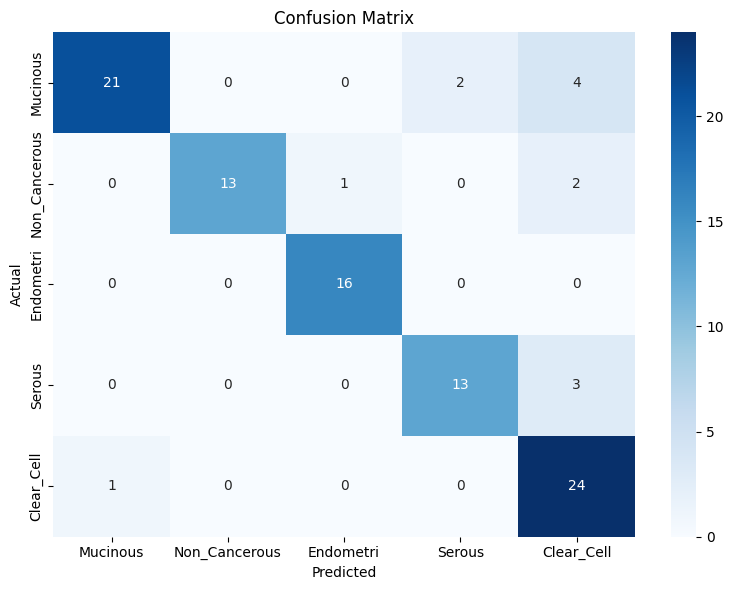

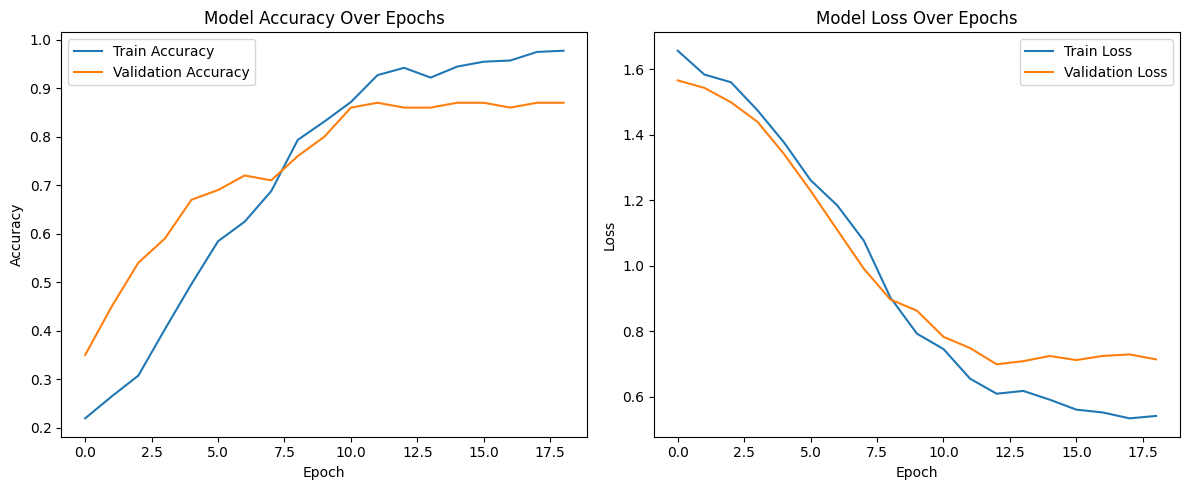

In [ ]:
# -----------------------------
# Confusion Matrix & Classification Report
# -----------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = model.predict([X_test_img, X_test_tab])
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# -----------------------------
# Accuracy and Loss Plots
# -----------------------------
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
